# Kirchner et al. 2019 - Triangle plots of Figure 5B,C and S7

In [1]:
import numpy as np
from scipy.stats import fisher_exact
import scipy
import ternary

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import cm, colors

## Load GO term meaning

In [2]:
with open('./newGO_custom_names.txt', 'r') as file:
    go_term = file.read()

In [3]:
go_term = go_term.split('\n')

go_dic = {}

for line in go_term:
    line = line.split(',')
    go_dic[line[0]] = line[1]

## Load result file

In [4]:
with open("./customGO_pz_triangle_groups.txt", 'r') as file:
    scores = file.read()

In [5]:
scores = scores.split('\n')
scores = [i.split('\t') for i in scores[:-1]]

In [8]:
terms = []

for line in scores:
    t = line[1][1:-1]
    if t not in terms:
        terms.append(t)

## Plotting functions

In [9]:
def coord_generator(scale=100, step=5):
    start = 0
    for i in np.arange(start=start, stop=scale+1, step=step):
        for j in np.arange(start=start, stop=scale + 1 - i, step=step):
            k = scale - i - j
            yield (i, j, k)

In [10]:
def prep_data_graph_cs():
    
    coord = coord_generator()
    coord_scaled = coord_generator(scale=20, step=1)
    res_zscore = {}
    res_pval = {}

    data = {}

    coresp_scales = {}
    for (i, j, k), (l, m, n) in zip(coord, coord_scaled):
        coresp_scales[(i,j,k)] = (l,m,n)

    for i,j,k in coord_scaled:
        data[(i,j,k)] = None

    for term in terms:   

        res_zscore[term] = data.copy()
        res_pval[term] = data.copy()
    
    for line in scores:
        
        fish = np.array([[int(line[6]), int(line[7])], [int(line[8]), int(line[9])]])
        _ , pval = fisher_exact(fish)

        data = {}
        i = int(line[2].split(', ')[0][2:])
        j = int(line[2].split(', ')[1])
        k = int(line[2].split(', ')[2][:-2])

        if not line[-2] == 'NA' and not np.isinf(float(line[-2])):
            res_zscore['{}'.format(line[1][1:-1])][coresp_scales[(i,j,k)]] = -np.log(pval) * float(line[-2])
        else:
            res_zscore['{}'.format(line[1][1:-1])][coresp_scales[(i,j,k)]] = 0
    
    return res_zscore

### Plot helper functions

In [12]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='ternary_centered'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(start, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, stop, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [13]:
def do_graph_dt(res_zscore, term_list=terms, output_folder = './png'):

    for i in np.arange(len(terms)):

        val = 200*list(res_zscore[terms[i]].values())

        if np.sum(val) != 0:

            vmax= np.max(val)
            vmin= np.absolute(np.min(val))

            if np.min(val) >= 0:
                col = cm.get_cmap('Blues')
            else:
                orig_cmap= cm.RdBu

                midpoint=1-vmax/(vmax+vmin)

                custom_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name="shifter_cmap_ternary")
                col = cm.get_cmap('shifter_cmap_ternary') 

            fig, ax = plt.subplots(figsize=(8,7))
            figure, tax = ternary.figure(scale=21, ax=ax)
            tax.boundary(linewidth=2.0)
            tax.heatmap(res_zscore[terms[i]], scale=20, style="dual-triangular", cmap=col)
            tax.gridlines(color="#777777", multiple=1)
            tax.boundary()
            tax.set_title('{num}: {desc}'.format(num=terms[i], desc=go_dic[terms[i]]))
            fontsize = 16
            tax.left_axis_label("acetyl. motif enrichment (%)", fontsize=fontsize)
            tax.right_axis_label("phos.  motif enrichment (%)", fontsize=fontsize)
            tax.bottom_axis_label("canon. motif enrichment (%)", fontsize=fontsize)
            tax.ticks(axis='lbr', multiple=2, linewidth=1, ticks=[0,20,40,60,80,100], fontsize=fontsize)

            tax.clear_matplotlib_ticks()
            plt.axis('off') 
            plt.tight_layout()
            plt.savefig('{}/{}.png'.format(output_folder, i), dpi=300)
            plt.savefig('{}/{}.eps'.format(output_folder, i))
            plt.close()
    print('Done!')
    

### Make Triangle Plots

In [14]:
data = prep_data_graph_cs()

In [15]:
do_graph_dt(res_zscore=data, output_folder='./dt/')

Done!


# Dummy plots for explanation

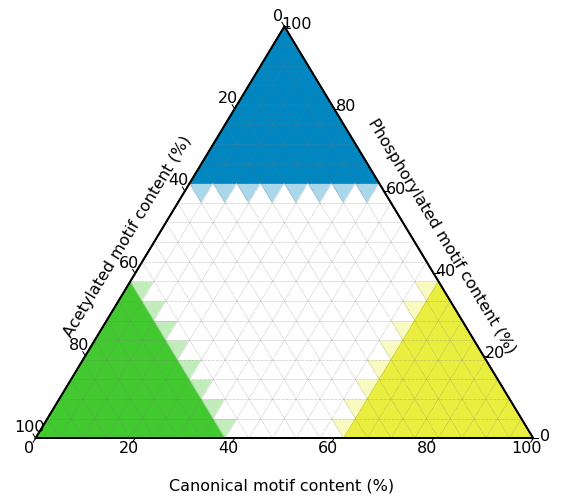

In [17]:
data={}
coord_scaled = coord_generator(scale=20, step=1)
for i,j,k in coord_scaled:
    if i>12:
        data[(i,j,k)] = (234/255, 239/255, 63/255, 1)
    elif j>12:
        data[(i,j,k)] = (0/255, 134/255, 192/255, 1)
    elif k>12:
        data[(i,j,k)] = (66/255, 201/255, 48/255, 1)
    else:
        data[(i,j,k)] = (1, 1, 1, 1)
        
fig, ax = plt.subplots(figsize=(8,7))
figure, tax = ternary.figure(scale=21, ax=ax)
tax.boundary(linewidth=2.0)
tax.heatmap(data, scale=20, style="dual-triangular", colormap=False)
tax.gridlines(color="#777777", multiple=1)
tax.boundary()
#tax.set_title('Enriched in Acetylated')
fontsize = 16
tax.left_axis_label("Acetylated motif content (%)", fontsize=fontsize)
tax.right_axis_label("Phosphorylated motif content (%)", fontsize=fontsize)
tax.bottom_axis_label("Canonical motif content (%)", fontsize=fontsize)
tax.ticks(axis='lbr', multiple=1, linewidth=1, ticks=[0,20,40,60,80,100], fontsize=fontsize)

tax.clear_matplotlib_ticks()
plt.axis('off') 
plt.tight_layout()
plt.savefig('./explanation_plot.png', dpi=300)
plt.show()